In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/net/tscratch/people/plghpiotr


In [2]:
%cd cl-adaptation/

/net/tscratch/people/plghpiotr/cl-adaptation


In [3]:
import torch

torch.cuda.is_available()

True

In [8]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from src.analysis import core
import re

DEVICE = "cuda"


get_digits = lambda str: int(re.sub(r"\D", "", str))


def is_sign_changed(output_1: torch.Tensor, output_2: torch.Tensor):
    return (output_1.mean(0) * output_2.mean(0)) < 0


def sign_mass(name_path: dict, device="cpu"):
    columns = len(name_path)

    # plt.rcParams.update({"font.size": 16})

    # fig, axs = plt.subplots(1, columns, dpi=100, figsize=(columns * 5, 1 * 5))

    # train_loader, _, test_loader, taskcla = data_factory[0]
    exp_analysis = defaultdict(list)

    for col, (exp_name, exp_path) in enumerate(name_path.items()):
        print(exp_name)
        cfg = core.create_cfg(exp_path)
        # cfg.data.num_workers = 1
        data_factory = core.DataFactory(cfg)
        _, _, test_loader, taskcla = data_factory[0]
        model_factory = core.ModelFactory(cfg, exp_path, device=device)

        for task_idx, ckpt in enumerate(sorted(model_factory.ckpts)):
            assert task_idx == get_digits(ckpt.name)
            if task_idx == 0:
                model = model_factory.create_model(
                    task=task_idx, num_classes=taskcla[1]
                )
                weights = model.heads[-1].weight
                outs_0 = core.get_activations(model.model, test_loader, device=device)
                continue

            model = model_factory.create_model(task=task_idx, num_classes=taskcla[1])
            outs = core.get_activations(model.model, test_loader, device=device)
            labels_signs = {}
            for label in outs_0.keys():
                d_changed = is_sign_changed(outs_0[label], outs[label])
                labels_signs[label] = d_changed
                # print(d_changed.sum())

            sorted_signs = torch.stack(
                [value for key, value in sorted(labels_signs.items())]
            )

            changed_mass = (
                sorted_signs * weights.abs() / weights.abs().sum(1).unsqueeze(1)
            ).sum(1)
            exp_analysis[exp_name].append(changed_mass)
            # print(
            #     f"{changed_mass.mean().item()=:.2f} {changed_mass.min().item()=:.2f} {changed_mass.max().item()=:.2f}"
            # )
    return exp_analysis

In [9]:
from pathlib import Path

# p = Path("models/cifar100_5/resnet34")
p = Path("models/cifar100_5/convnext")
expname_path = {}
for dir in p.iterdir():
    for i in dir.iterdir():
        path = i.readlink()
        exp_name = "_".join(i.parts[2:])
        expname_path[exp_name] = path

In [10]:
expname_path

{'convnext_finetuning_reg': PosixPath('results/2024/04.24/13-34-44/0/cifar100_fixed_finetuning'),
 'convnext_finetuning_noreg': PosixPath('results/2024/04.17/18-12-39/0/cifar100_fixed_finetuning_final_checkpoint'),
 'convnext_ewc_reg': PosixPath('results/2024/04.24/13-34-32/4/cifar100_fixed_ewc'),
 'convnext_ewc_noreg': PosixPath('results/2024/04.22/23-58-48/0/cifar100_fixed_ewc_final_checkpoint'),
 'convnext_lwf_reg': PosixPath('results/2024/04.24/13-35-04/0/cifar100_fixed_lwf'),
 'convnext_lwf_noreg': PosixPath('results/2024/04.27/10-23-48/0/cifar100_fixed_lwf'),
 'convnext_replay_reg': PosixPath('results/2024/04.24/13-34-32/2/cifar100_fixed_finetuning'),
 'convnext_replay_noreg': PosixPath('results/2024/04.17/18-12-39/1/cifar100_fixed_finetuning_final_checkpoint')}

In [11]:
finetuning_exps = {
    # "resnet34_finetuning_reg": "results/2024/04.24/13-35-10/0/cifar100_fixed_finetuning",
    "resnet34_finetuning_noreg": "results/2024/04.17/18-13-25/0/cifar100_fixed_finetuning_final_checkpoint",
}

In [12]:
exp_analysis = sign_mass(expname_path, DEVICE)

convnext_finetuning_reg
Files already downloaded and verified
Files already downloaded and verified


/net/tscratch/people/plghpiotr/.conda/mgr_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/net/tscratch/people/plghpiotr/.conda/mgr_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.71it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.94it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.22it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.87it/s]


convnext_finetuning_noreg
Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.17it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.56it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.57it/s]


convnext_ewc_reg
Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.43it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.69it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.65it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.55it/s]


convnext_ewc_noreg
Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.15it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.61it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.67it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.49it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.70it/s]


convnext_lwf_reg
Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.57it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.17it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.04it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.34it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.11it/s]


convnext_lwf_noreg
Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.11it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.80it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.54it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.35it/s]


convnext_replay_reg
Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.36it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.75it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.48it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.64it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.50it/s]


convnext_replay_noreg
Files already downloaded and verified
Files already downloaded and verified
<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.08it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.53it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.53it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.62it/s]


<All keys matched successfully>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.46it/s]


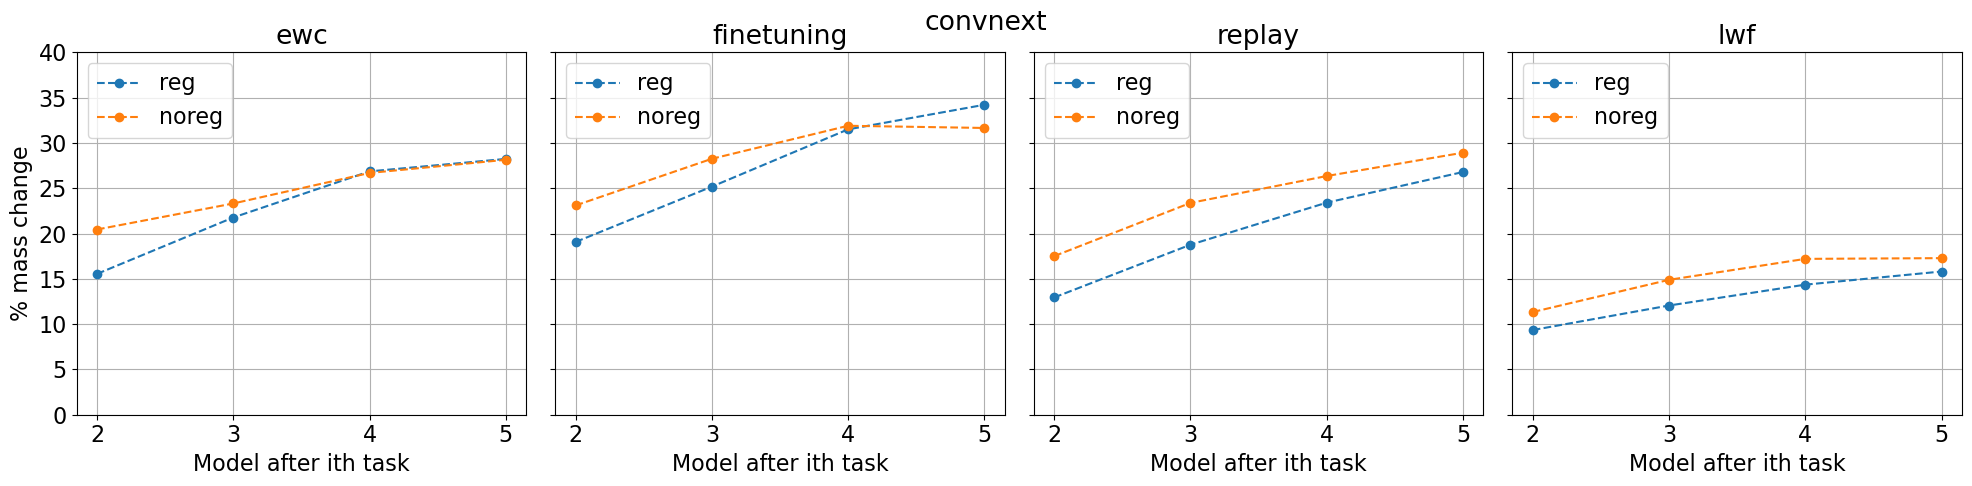

In [55]:
import re


def plt_subplots(exp_analysis):
    methods_pattern = re.compile(r"^.*_(.*)_")
    methods = set([methods_pattern.match(key).group(1) for key in exp_analysis.keys()])
    fig, axs = plt.subplots(1, len(methods), figsize=(20, 5))
    for i, method in enumerate(methods):
        exp_names = [exp_name for exp_name in exp_analysis.keys() if method in exp_name]
        for name in exp_names:
            arr = (
                np.array([task_a.detach().cpu() for task_a in exp_analysis[name]]) * 100
            )
            net_name, method_name, is_reg_name = name.split("_")

            steps = range(2, arr.shape[0] + 2)
            axs[i].plot(steps, arr.mean(1), "o--", label=is_reg_name)
            axs[i].set_ylim([0, 40])
            axs[i].set_xticks(steps)
            axs[i].legend(loc="upper left", fancybox=True, shadow=False)
            axs[i].grid(b=True, which="major", linestyle="-")
            axs[i].set_title(method_name)
        if i == 0:
            axs[i].set_ylabel("% mass change")
        else:
            axs[i].set(ylabel="", yticklabels=[])
        axs[i].set_xlabel("Model after ith task")
    fig.tight_layout()
    fig.suptitle(net_name)
    plt.show()


plt_subplots(exp_analysis)

(0.0, 45.0)

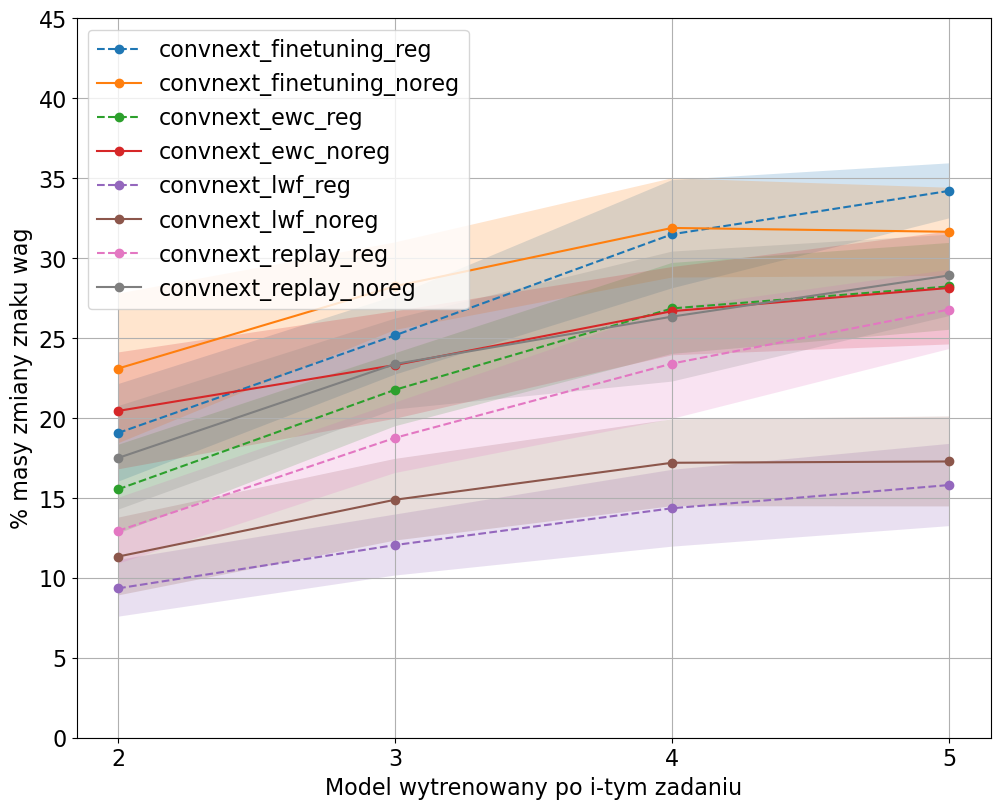

In [13]:
plt.figure(figsize=(10, 8))
plt.rcParams.update({"font.size": 16})
for exp_name, task_analysis in exp_analysis.items():
    arr = np.array([task_a.detach().cpu() for task_a in task_analysis]) * 100
    marker = "o-" if "noreg" in exp_name else "o--"
    steps = list(range(2, len(task_analysis) + 2))
    plt.plot(steps, arr.mean(1), marker, label=exp_name)
    plt.fill_between(
        steps,
        arr.mean(1) - arr.std(1),
        arr.mean(1) + arr.std(1),
        # color="gray",
        alpha=0.2,
    )
plt.legend(loc="upper left", fancybox=True, shadow=False)
plt.grid()
plt.tight_layout()
plt.xticks(steps)
plt.xlabel("Model wytrenowany po i-tym zadaniu")
plt.ylabel("% masy zmiany znaku wag")
# plt.title("Ważona zmiana znaku wektora cech na danych z pierwszego zadania")
plt.ylim(0, 45)

In [42]:
exp_analysis

defaultdict(list,
            {'convnext_finetuning_reg': [tensor([0.1731, 0.2009, 0.2617, 0.2184, 0.2624, 0.1659, 0.1949, 0.1563, 0.1427,
                      0.2093, 0.2068, 0.1778, 0.1711, 0.1904, 0.1833, 0.1585, 0.2012, 0.1788,
                      0.1944, 0.1653], device='cuda:0', grad_fn=<SumBackward1>),
              tensor([0.2175, 0.2718, 0.3123, 0.2836, 0.2849, 0.2293, 0.2567, 0.2421, 0.2298,
                      0.2524, 0.2470, 0.2323, 0.2663, 0.2743, 0.2434, 0.2163, 0.2511, 0.2348,
                      0.2644, 0.2246], device='cuda:0', grad_fn=<SumBackward1>),
              tensor([0.3135, 0.3702, 0.3278, 0.3508, 0.3617, 0.2949, 0.3486, 0.2768, 0.2505,
                      0.3239, 0.3375, 0.3084, 0.3157, 0.2555, 0.3593, 0.2871, 0.2796, 0.2967,
                      0.3366, 0.3046], device='cuda:0', grad_fn=<SumBackward1>),
              tensor([0.3425, 0.3583, 0.3295, 0.3266, 0.3561, 0.3515, 0.3352, 0.3401, 0.2966,
                      0.3315, 0.3869, 0.3342, 0.3445, 